In [1]:
import zipfile
from urllib import request
import imutils
import matplotlib.image as mpimg
import random
%matplotlib inline
import cv2
from glob import glob
import keras,math
import cv2 as cv 
import pandas as pd
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Reshape ,MaxPooling2D, advanced_activations
from keras.layers import concatenate, Concatenate,Dense, Flatten,SeparableConv2D,LeakyReLU,GlobalAveragePooling2D
from keras.layers import BatchNormalization, RepeatVector, Permute, Activation, Reshape, Flatten,Multiply
from keras.layers.advanced_activations import PReLU

from keras.layers import Lambda,Add,Dropout,SpatialDropout2D,DepthwiseConv2D,normalization
from keras.models import Sequential, Model 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.backend import clear_session
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.layers import MaxPooling2D, Input, Dense, Flatten
import numpy as np
from PIL import Image
import os
from skimage.transform import resize
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.gridspec as gridspec
 
import tensorflow as tf 
import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
 
# aita die akta tensor e sob image k nie astasi
 
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Lambda,Subtract,concatenate,Add,merge,add
#from SpectralNormalizationKeras import DenseSN, ConvSN2D

from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Lambda,Subtract,concatenate,Add,merge,add
#from SpectralNormalizationKeras import DenseSN, ConvSN2D

 
 
from keras.optimizers import Adam 

Using TensorFlow backend.


# Dataset loading

In [2]:
x_train = np.load('train_im.npy')
y_train = np.load('train_lb.npy')
x_test = np.load('test_im.npy')

re=list()

for i in range(len(y_train)):
    a=y_train[i]
    b=np.expand_dims(a, axis = 2)
    re.append(b)


re=np.asarray(re)
x_label=re 

print(x_train.shape, x_label.shape)
print(x_test.shape )


(670, 128, 128, 3) (670, 128, 128, 1)
(65, 128, 128, 3)


In [3]:
 
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true) + K.sum(y_pred) + K.epsilon())
 
def plot_sample(lr, sr):
    plt.figure(figsize=(10, 8))

    images = [lr, sr]
    titles = ['recovered map', 'input image']

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 2, i+1)
        plt.imshow(img,cmap='gray')
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
def imgps(x):
    p = x[0] * 255
    p = p.astype(np.uint8)
    p = Image.fromarray(p)
    return p

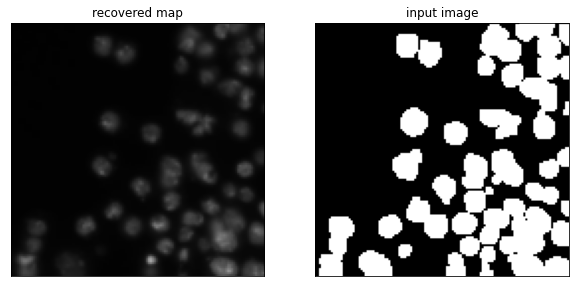

In [4]:
ind=6
a=x_train[ind] 
b=x_label[ind]
b=np.squeeze(b)
plot_sample(a,b)

In [5]:
def unt3(ip,f):
  
    conv1 = Conv2D(f, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(ip)
    conv1 = Conv2D(f, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    
    conv2 = Conv2D(f*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(f*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    
    conv3 = Conv2D(f*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(f*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    
    conv4 = Conv2D(f*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(f*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    

    conv5 = Conv2D( f*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(f*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    
    u5=Conv2DTranspose(f, 3, strides=16,activation='relu', padding='same')(drop5)
    u4=Conv2DTranspose(f, 3, strides=8,activation='relu', padding='same')(pool3)
    u4= add([u4,u5])
    
    
    u3=Conv2DTranspose(f, 3, strides=4,activation='relu', padding='same')(pool2)
    u3= add([u3,u4,u5])
    
    u2=Conv2DTranspose(f, 3, strides=2,activation='relu', padding='same')(pool1)
    u2= add([u2,u3,u4,u5])
    
    u1=Conv2DTranspose(f, 3, strides=1,activation='relu', padding='same')(ip)
    u1= add([u1,u2,u3,u4,u5])
    
    
    
    col = concatenate([u1,u2,u3,u4,u5], axis = 3)
    col = Conv2D(3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(col)
    ip = Conv2D(3, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(ip)
    sm = add([col,ip])

 
    x = Conv2D(3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(sm)
        
 
    return x


In [17]:
w=128
input_img = Input(shape=(w,w,3))

x1 = Conv2D(32, 7, activation ='relu', padding = 'same', kernel_initializer = 'he_normal')(input_img)
x1 = Conv2D(3, (1,1), activation ='relu', padding = 'same', kernel_initializer = 'he_normal')(x1)
x1=unt3(x1,16) 
x = Conv2D(1, (1,1), activation ='sigmoid', padding = 'same', kernel_initializer = 'he_normal')(x1)

 
 

model = Model(input_img, x)

In [18]:
model.compile(optimizer = Adam(lr=2e-4) ,
                          loss = 'binary_crossentropy', metrics = [dice_coef])

In [19]:
 

filepath="B_seg3.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=False, 
                             mode='min')

In [20]:
model.fit(x_train, x_label, validation_split = .2, epochs = 70000, batch_size = 8, shuffle =  True, callbacks =  [checkpoint ])

Train on 536 samples, validate on 134 samples
Epoch 1/70000
536/536 [==============================] - 4s 8ms/step - loss: 0.7775 - dice_coef: 0.2923 - val_loss: 0.6819 - val_dice_coef: 0.2822

Epoch 00001: saving model to B_seg3.hdf5
Epoch 2/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.6687 - dice_coef: 0.2953 - val_loss: 0.6347 - val_dice_coef: 0.2949

Epoch 00002: saving model to B_seg3.hdf5
Epoch 3/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.5741 - dice_coef: 0.3207 - val_loss: 0.4889 - val_dice_coef: 0.3364

Epoch 00003: saving model to B_seg3.hdf5
Epoch 4/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.4280 - dice_coef: 0.3790 - val_loss: 0.3172 - val_dice_coef: 0.4318

Epoch 00004: saving model to B_seg3.hdf5
Epoch 5/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.3173 - dice_coef: 0.4599 - val_loss: 0.3114 - val_dice_coef: 0.4464

Epoch 00005: saving model to B_seg3.hdf5
Epoch 6/7

Epoch 44/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.1337 - dice_coef: 0.8063 - val_loss: 0.1042 - val_dice_coef: 0.8365

Epoch 00044: saving model to B_seg3.hdf5
Epoch 45/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.1401 - dice_coef: 0.8019 - val_loss: 0.1051 - val_dice_coef: 0.8290

Epoch 00045: saving model to B_seg3.hdf5
Epoch 46/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.1247 - dice_coef: 0.8165 - val_loss: 0.1049 - val_dice_coef: 0.8371

Epoch 00046: saving model to B_seg3.hdf5
Epoch 47/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.1180 - dice_coef: 0.8241 - val_loss: 0.1017 - val_dice_coef: 0.8350

Epoch 00047: saving model to B_seg3.hdf5
Epoch 48/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.1172 - dice_coef: 0.8242 - val_loss: 0.1017 - val_dice_coef: 0.8346

Epoch 00048: saving model to B_seg3.hdf5
Epoch 49/70000
536/536 [==========================

536/536 [==============================] - 2s 4ms/step - loss: 0.0937 - dice_coef: 0.8636 - val_loss: 0.0866 - val_dice_coef: 0.8725

Epoch 00087: saving model to B_seg3.hdf5
Epoch 88/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0921 - dice_coef: 0.8659 - val_loss: 0.0873 - val_dice_coef: 0.8713

Epoch 00088: saving model to B_seg3.hdf5
Epoch 89/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0912 - dice_coef: 0.8651 - val_loss: 0.0887 - val_dice_coef: 0.8717

Epoch 00089: saving model to B_seg3.hdf5
Epoch 90/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0925 - dice_coef: 0.8654 - val_loss: 0.0882 - val_dice_coef: 0.8725

Epoch 00090: saving model to B_seg3.hdf5
Epoch 91/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0923 - dice_coef: 0.8664 - val_loss: 0.0878 - val_dice_coef: 0.8655

Epoch 00091: saving model to B_seg3.hdf5
Epoch 92/70000
536/536 [==============================] - 2s 4ms/

536/536 [==============================] - 2s 4ms/step - loss: 0.0801 - dice_coef: 0.8824 - val_loss: 0.0844 - val_dice_coef: 0.8814

Epoch 00130: saving model to B_seg3.hdf5
Epoch 131/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0819 - dice_coef: 0.8806 - val_loss: 0.0847 - val_dice_coef: 0.8844

Epoch 00131: saving model to B_seg3.hdf5
Epoch 132/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0789 - dice_coef: 0.8845 - val_loss: 0.0837 - val_dice_coef: 0.8780

Epoch 00132: saving model to B_seg3.hdf5
Epoch 133/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0802 - dice_coef: 0.8800 - val_loss: 0.0920 - val_dice_coef: 0.8793

Epoch 00133: saving model to B_seg3.hdf5
Epoch 134/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0793 - dice_coef: 0.8830 - val_loss: 0.0825 - val_dice_coef: 0.8870

Epoch 00134: saving model to B_seg3.hdf5
Epoch 135/70000
536/536 [==============================] - 2s

Epoch 173/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0752 - dice_coef: 0.8892 - val_loss: 0.0808 - val_dice_coef: 0.8875

Epoch 00173: saving model to B_seg3.hdf5
Epoch 174/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0741 - dice_coef: 0.8893 - val_loss: 0.0809 - val_dice_coef: 0.8896

Epoch 00174: saving model to B_seg3.hdf5
Epoch 175/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0729 - dice_coef: 0.8939 - val_loss: 0.0826 - val_dice_coef: 0.8879

Epoch 00175: saving model to B_seg3.hdf5
Epoch 176/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0728 - dice_coef: 0.8934 - val_loss: 0.0832 - val_dice_coef: 0.8886

Epoch 00176: saving model to B_seg3.hdf5
Epoch 177/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0729 - dice_coef: 0.8922 - val_loss: 0.0811 - val_dice_coef: 0.8889

Epoch 00177: saving model to B_seg3.hdf5
Epoch 178/70000
536/536 [====================

Epoch 216/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0673 - dice_coef: 0.9021 - val_loss: 0.0826 - val_dice_coef: 0.8935

Epoch 00216: saving model to B_seg3.hdf5
Epoch 217/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0666 - dice_coef: 0.9030 - val_loss: 0.0831 - val_dice_coef: 0.8945

Epoch 00217: saving model to B_seg3.hdf5
Epoch 218/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0665 - dice_coef: 0.9023 - val_loss: 0.0841 - val_dice_coef: 0.8931

Epoch 00218: saving model to B_seg3.hdf5
Epoch 219/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0660 - dice_coef: 0.9032 - val_loss: 0.0834 - val_dice_coef: 0.8906

Epoch 00219: saving model to B_seg3.hdf5
Epoch 220/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0655 - dice_coef: 0.9041 - val_loss: 0.0864 - val_dice_coef: 0.8911

Epoch 00220: saving model to B_seg3.hdf5
Epoch 221/70000
536/536 [====================

Epoch 259/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0644 - dice_coef: 0.9061 - val_loss: 0.0849 - val_dice_coef: 0.8934

Epoch 00259: saving model to B_seg3.hdf5
Epoch 260/70000
536/536 [==============================] - 2s 5ms/step - loss: 0.0636 - dice_coef: 0.9070 - val_loss: 0.0834 - val_dice_coef: 0.8960

Epoch 00260: saving model to B_seg3.hdf5
Epoch 261/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0613 - dice_coef: 0.9097 - val_loss: 0.0835 - val_dice_coef: 0.8944

Epoch 00261: saving model to B_seg3.hdf5
Epoch 262/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0622 - dice_coef: 0.9083 - val_loss: 0.0890 - val_dice_coef: 0.8957

Epoch 00262: saving model to B_seg3.hdf5
Epoch 263/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0605 - dice_coef: 0.9114 - val_loss: 0.0844 - val_dice_coef: 0.8938

Epoch 00263: saving model to B_seg3.hdf5
Epoch 264/70000
536/536 [====================

Epoch 302/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0573 - dice_coef: 0.9161 - val_loss: 0.0868 - val_dice_coef: 0.8919

Epoch 00302: saving model to B_seg3.hdf5
Epoch 303/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0579 - dice_coef: 0.9158 - val_loss: 0.0857 - val_dice_coef: 0.8950

Epoch 00303: saving model to B_seg3.hdf5
Epoch 304/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0581 - dice_coef: 0.9147 - val_loss: 0.0864 - val_dice_coef: 0.8992

Epoch 00304: saving model to B_seg3.hdf5
Epoch 305/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0582 - dice_coef: 0.9148 - val_loss: 0.0865 - val_dice_coef: 0.8987

Epoch 00305: saving model to B_seg3.hdf5
Epoch 306/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0575 - dice_coef: 0.9158 - val_loss: 0.0862 - val_dice_coef: 0.8970

Epoch 00306: saving model to B_seg3.hdf5
Epoch 307/70000
536/536 [====================

Epoch 345/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0560 - dice_coef: 0.9180 - val_loss: 0.0887 - val_dice_coef: 0.8991

Epoch 00345: saving model to B_seg3.hdf5
Epoch 346/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0544 - dice_coef: 0.9208 - val_loss: 0.0898 - val_dice_coef: 0.8996

Epoch 00346: saving model to B_seg3.hdf5
Epoch 347/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0540 - dice_coef: 0.9212 - val_loss: 0.0888 - val_dice_coef: 0.9001

Epoch 00347: saving model to B_seg3.hdf5
Epoch 348/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0551 - dice_coef: 0.9205 - val_loss: 0.0911 - val_dice_coef: 0.8966

Epoch 00348: saving model to B_seg3.hdf5
Epoch 349/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0552 - dice_coef: 0.9199 - val_loss: 0.0879 - val_dice_coef: 0.8977

Epoch 00349: saving model to B_seg3.hdf5
Epoch 350/70000
536/536 [====================

Epoch 388/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0534 - dice_coef: 0.9229 - val_loss: 0.0930 - val_dice_coef: 0.8963

Epoch 00388: saving model to B_seg3.hdf5
Epoch 389/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0523 - dice_coef: 0.9244 - val_loss: 0.0940 - val_dice_coef: 0.8984

Epoch 00389: saving model to B_seg3.hdf5
Epoch 390/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0519 - dice_coef: 0.9247 - val_loss: 0.0926 - val_dice_coef: 0.8997

Epoch 00390: saving model to B_seg3.hdf5
Epoch 391/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0520 - dice_coef: 0.9242 - val_loss: 0.0904 - val_dice_coef: 0.8992

Epoch 00391: saving model to B_seg3.hdf5
Epoch 392/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0521 - dice_coef: 0.9246 - val_loss: 0.0974 - val_dice_coef: 0.8993

Epoch 00392: saving model to B_seg3.hdf5
Epoch 393/70000
536/536 [====================

Epoch 431/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0511 - dice_coef: 0.9264 - val_loss: 0.0974 - val_dice_coef: 0.8986

Epoch 00431: saving model to B_seg3.hdf5
Epoch 432/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0505 - dice_coef: 0.9269 - val_loss: 0.0964 - val_dice_coef: 0.8952

Epoch 00432: saving model to B_seg3.hdf5
Epoch 433/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0561 - dice_coef: 0.9212 - val_loss: 0.0924 - val_dice_coef: 0.8839

Epoch 00433: saving model to B_seg3.hdf5
Epoch 434/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0619 - dice_coef: 0.9107 - val_loss: 0.0903 - val_dice_coef: 0.8983

Epoch 00434: saving model to B_seg3.hdf5
Epoch 435/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0550 - dice_coef: 0.9201 - val_loss: 0.0919 - val_dice_coef: 0.8991

Epoch 00435: saving model to B_seg3.hdf5
Epoch 436/70000
536/536 [====================

Epoch 474/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0496 - dice_coef: 0.9288 - val_loss: 0.0958 - val_dice_coef: 0.8981

Epoch 00474: saving model to B_seg3.hdf5
Epoch 475/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0490 - dice_coef: 0.9281 - val_loss: 0.0987 - val_dice_coef: 0.8997

Epoch 00475: saving model to B_seg3.hdf5
Epoch 476/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0487 - dice_coef: 0.9306 - val_loss: 0.0953 - val_dice_coef: 0.8955

Epoch 00476: saving model to B_seg3.hdf5
Epoch 477/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0496 - dice_coef: 0.9268 - val_loss: 0.0995 - val_dice_coef: 0.8982

Epoch 00477: saving model to B_seg3.hdf5
Epoch 478/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0536 - dice_coef: 0.9234 - val_loss: 0.0959 - val_dice_coef: 0.8990

Epoch 00478: saving model to B_seg3.hdf5
Epoch 479/70000
536/536 [====================

Epoch 517/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0500 - dice_coef: 0.9265 - val_loss: 0.0967 - val_dice_coef: 0.9005

Epoch 00517: saving model to B_seg3.hdf5
Epoch 518/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0473 - dice_coef: 0.9316 - val_loss: 0.0954 - val_dice_coef: 0.8983

Epoch 00518: saving model to B_seg3.hdf5
Epoch 519/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0472 - dice_coef: 0.9319 - val_loss: 0.1000 - val_dice_coef: 0.8988

Epoch 00519: saving model to B_seg3.hdf5
Epoch 520/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0476 - dice_coef: 0.9306 - val_loss: 0.0975 - val_dice_coef: 0.9008

Epoch 00520: saving model to B_seg3.hdf5
Epoch 521/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0473 - dice_coef: 0.9318 - val_loss: 0.1042 - val_dice_coef: 0.8931

Epoch 00521: saving model to B_seg3.hdf5
Epoch 522/70000
536/536 [====================

Epoch 560/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0529 - dice_coef: 0.9244 - val_loss: 0.0975 - val_dice_coef: 0.8972

Epoch 00560: saving model to B_seg3.hdf5
Epoch 561/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0460 - dice_coef: 0.9323 - val_loss: 0.1017 - val_dice_coef: 0.8988

Epoch 00561: saving model to B_seg3.hdf5
Epoch 562/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0466 - dice_coef: 0.9327 - val_loss: 0.0969 - val_dice_coef: 0.8996

Epoch 00562: saving model to B_seg3.hdf5
Epoch 563/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0464 - dice_coef: 0.9330 - val_loss: 0.0997 - val_dice_coef: 0.8966

Epoch 00563: saving model to B_seg3.hdf5
Epoch 564/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0460 - dice_coef: 0.9329 - val_loss: 0.0954 - val_dice_coef: 0.9011

Epoch 00564: saving model to B_seg3.hdf5
Epoch 565/70000
536/536 [====================

Epoch 603/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0468 - dice_coef: 0.9330 - val_loss: 0.1009 - val_dice_coef: 0.9018

Epoch 00603: saving model to B_seg3.hdf5
Epoch 604/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0475 - dice_coef: 0.9320 - val_loss: 0.1001 - val_dice_coef: 0.9004

Epoch 00604: saving model to B_seg3.hdf5
Epoch 605/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0462 - dice_coef: 0.9335 - val_loss: 0.1006 - val_dice_coef: 0.9006

Epoch 00605: saving model to B_seg3.hdf5
Epoch 606/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0460 - dice_coef: 0.9337 - val_loss: 0.1002 - val_dice_coef: 0.9004

Epoch 00606: saving model to B_seg3.hdf5
Epoch 607/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0448 - dice_coef: 0.9350 - val_loss: 0.1012 - val_dice_coef: 0.9007

Epoch 00607: saving model to B_seg3.hdf5
Epoch 608/70000
536/536 [====================

Epoch 646/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0436 - dice_coef: 0.9366 - val_loss: 0.1045 - val_dice_coef: 0.8991

Epoch 00646: saving model to B_seg3.hdf5
Epoch 647/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0443 - dice_coef: 0.9360 - val_loss: 0.1033 - val_dice_coef: 0.9004

Epoch 00647: saving model to B_seg3.hdf5
Epoch 648/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0488 - dice_coef: 0.9306 - val_loss: 0.1033 - val_dice_coef: 0.8999

Epoch 00648: saving model to B_seg3.hdf5
Epoch 649/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0451 - dice_coef: 0.9347 - val_loss: 0.1003 - val_dice_coef: 0.9017

Epoch 00649: saving model to B_seg3.hdf5
Epoch 650/70000
536/536 [==============================] - 2s 4ms/step - loss: 0.0446 - dice_coef: 0.9358 - val_loss: 0.1114 - val_dice_coef: 0.8958

Epoch 00650: saving model to B_seg3.hdf5
Epoch 651/70000
536/536 [====================

KeyboardInterrupt: 

In [21]:
model.save('B_seg3.h5')   


## Testing

In [22]:
val=x_test

In [23]:
val.shape

(65, 128, 128, 3)

In [24]:
model.load_weights('B_seg3.h5')
per =  model.predict(val)
 

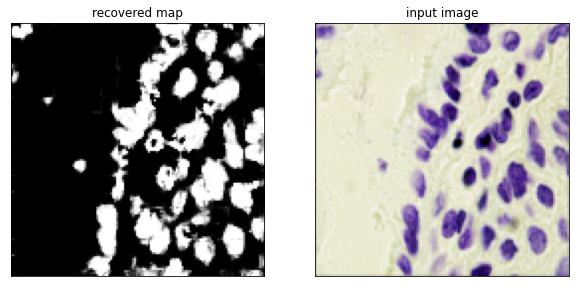

In [27]:
i=22
 
p=per[i]  
p= np.squeeze(p)
p=p.astype('float32')
 
q=val[i]
plot_sample( p,q)